In [95]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_core as k

from sklearn.model_selection import train_test_split

import tensorflow 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop 
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [96]:
class Config:
    SEED = 42
    EPOCHS = 20
    BATCH_SIZE = 64
    IMAGE_SIZE = [256, 256]
    AUTOTUNE = tf.data.AUTOTUNE
config = Config()

In [29]:
# BASE_PATH = "/kaggle/input/digit-recognizer"
# print(os.listdir('/kaggle/input/digit-recognizer'))
BASE_PATH = "/Users/Riley/Desktop/ML/Datasets/digits_dataset"
print(os.listdir(BASE_PATH))


['test.csv', 'submission.csv', 'train.csv', 'sample_submission.csv']


In [30]:
train = pd.read_csv(f"{BASE_PATH}/train.csv")
test = pd.read_csv(f"{BASE_PATH}/test.csv")
submission = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")

print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [31]:
# put labels into y_train variable
y_train = train["label"]

# Drop 'label' column
X_train = train.drop("label",axis = 1) 

X_train.shape, y_train.shape

((42000, 784), (42000,))

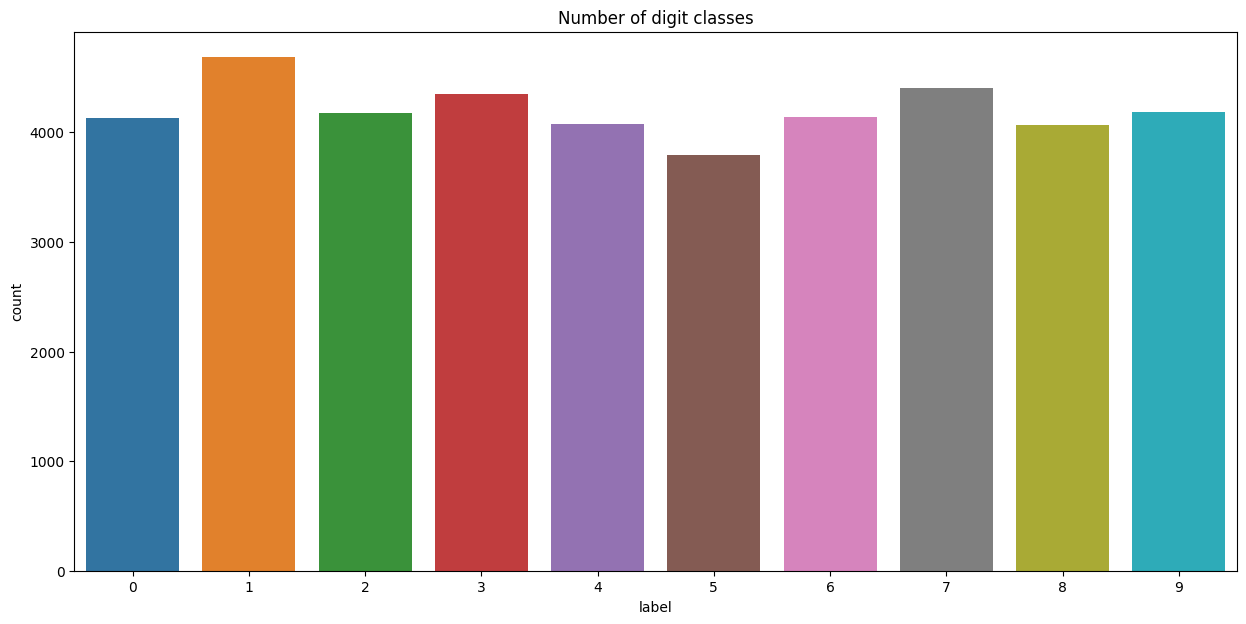

In [32]:
# visualize number of digits classes

plt.figure(figsize=(15,7))
sns.countplot(x = 'label', data = train)
plt.title("Number of digit classes");

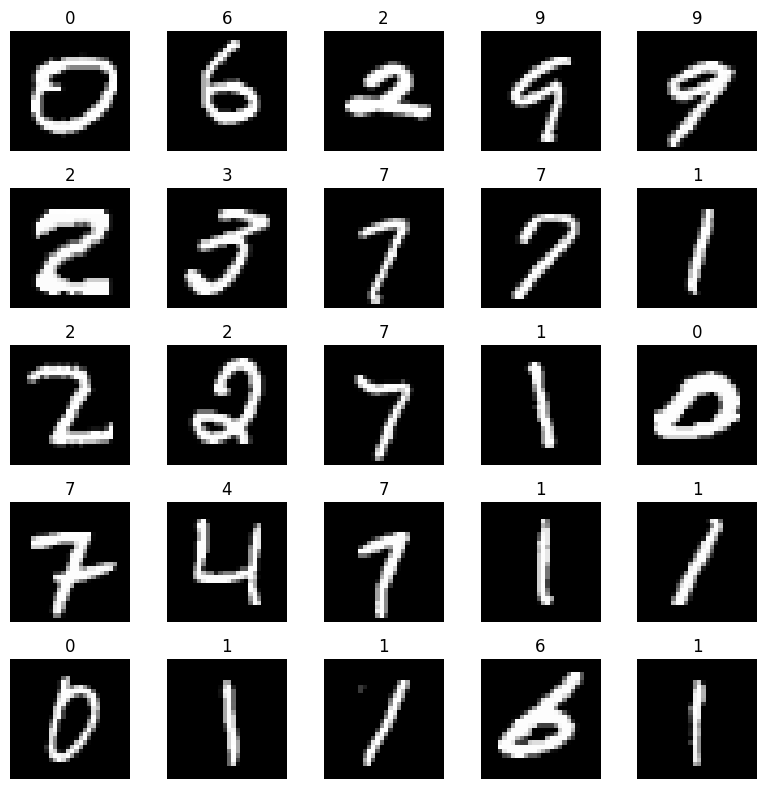

In [33]:
np.random.seed(42)
random_indices = np.random.randint(0, 42000, 25)

images=[]
labels=[]
for i in random_indices:
    img = X_train.iloc[i].to_numpy()
    img = img.reshape((28,28,1))
    images.append(img)
    label = y_train[i]
    labels.append(label)
    
# Plot the images
plt.subplots(figsize = (8, 8))
for i, image in enumerate(images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(labels[i])
    plt.axis('off')


plt.tight_layout()
plt.show()

## 3- Normalization, Reshape and Label Encoding 
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28) 
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [34]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# Label Encoding 
y_train = to_categorical(y_train, num_classes = 10)

# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 28, 28, 1) (33600, 10)
(8400, 28, 28, 1) (8400, 10)


# Data Augmentation 

To avoid overfitting problem.


In [36]:
datagen = ImageDataGenerator(
    
        featurewise_center = False,  
        samplewise_center = False,  
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,  
    
        rotation_range = 20,  
        zoom_range = 0.2, 
        width_shift_range = 0.2,  
        height_shift_range = 0.2,  
    
        horizontal_flip = False,  
        vertical_flip = False)  

train_gen = datagen.flow(X_train, y_train, batch_size=128)
val_gen = datagen.flow(X_val, y_val, batch_size=128)

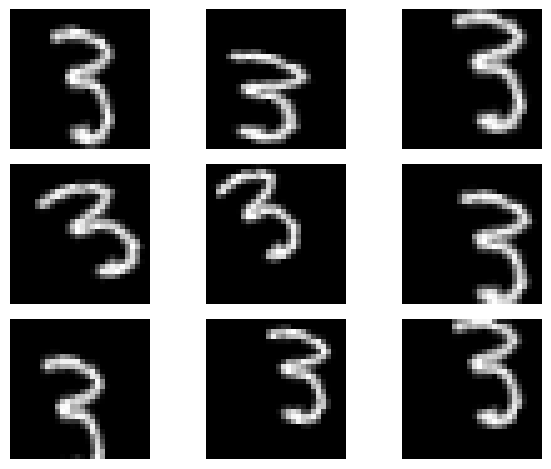

In [37]:
img = X_train[2].reshape((1, 28, 28, 1))

for i, batch in enumerate (datagen.flow(img, batch_size = 1)):
  
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0], cmap='gray')
    plt.axis('off')
    
    if i == 8: break

# Show the plot
plt.tight_layout()
plt.show()

# modeling

In [74]:
def model():
    model = Sequential([
        
    Conv2D(64, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    Conv2D(64, kernel_size = (3,3), padding = 'Same', activation ='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
        
    Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    Conv2D(128, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size = (3,3), activation="relu"),
    MaxPooling2D(2,2),
    BatchNormalization(),
        
    Flatten(),
    Dense(512, activation = "relu"),
    Dropout(0.5),

    Dense(10, activation = "softmax"),
    ])

    return model

model = model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 128)      

In [75]:
#optimizer = Adam(learning_rate=0.001)
#model_1.compile(optimizer= optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [84]:
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=20, 
    alpha=0.0,
    warmup_steps=3,
    warmup_target=1e-3) 


optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [85]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    patience=5, 
    verbose=1,
    mode="max", 
    restore_best_weights=True)

In [87]:
history = model.fit_generator(
    train_gen, 
    epochs = 3,
    steps_per_epoch = X_train.shape[0] // 128,
    validation_data = val_gen,
    validation_steps = X_val.shape[0] // 128,
    callbacks = [learning_rate_reduction, early_stopping],
    verbose = 1)

Epoch 1/3
262/262 [==============================] - 46s 174ms/step - loss: 0.0888 - accuracy: 0.9741 - val_loss: 0.1289 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 2/3
262/262 [==============================] - 45s 173ms/step - loss: 0.0733 - accuracy: 0.9790 - val_loss: 0.1310 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 3/3
262/262 [==============================] - 45s 172ms/step - loss: 0.0704 - accuracy: 0.9798 - val_loss: 0.0758 - val_accuracy: 0.9757 - lr: 0.0010


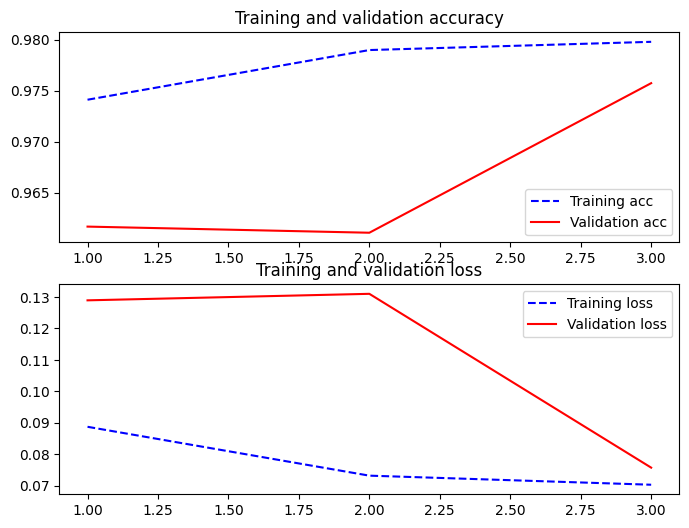

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize = (8, 6))

epochs = range(1, len(acc) + 1)
ax[0].plot(epochs, acc, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [89]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print('---------------------')
print('Train loss:', round(train_loss,4))
print('Train accuracy:', round(train_accuracy,4))
print('Val loss:', round(val_loss,4))
print('Val accuracy:', round(val_accuracy,4))

263/263 [==============================] - 4s 15ms/step - loss: 2.4832 - accuracy: 0.1082
---------------------
Train loss: 2.481
Train accuracy: 0.1124
Val loss: 2.4832
Val accuracy: 0.1082


In [90]:
val_predict = model.predict(X_val)
val_predict_labels = np.argmax(val_predict, axis = 1)

val_true_labels = np.argmax(y_val, axis = 1)
num_errors = np.count_nonzero(val_predict_labels != val_true_labels)

print(f'Number of error predictions: {num_errors}')

263/263 [==============================] - 4s 15ms/step
Number of error predictions: 227


In [92]:
print(f'the percentage of errors is {(num_errors/len(y_val))}')

the percentage of errors is 0.027023809523809523


In [94]:
predict_x = model.predict(test)  
class_x = np.argmax(predict_x, axis=1)

submission['Label'] = class_x
submission.to_csv(f"{BASE_PATH}/submission.csv", index= False)

submission.head()

129/875 [===>..........................] - ETA: 10s

KeyboardInterrupt: 